## Notebook 5: Multi-objective optimization of heating and cooling loads

**1. Prepare Problem**

In [1]:
#! pip install pip install scikit-optimize

In [2]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from SALib.analyze import sobol
from SALib.sample.sobol import sample as sobol_sample
from SALib.analyze import sobol as sobol_analyze

from sklearn.ensemble import RandomForestRegressor

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.problems.functional import FunctionalProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.core.termination import Termination

import pickle
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [3]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [4]:
# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load'], axis = 1)
y = data[['Heating Load', 'Cooling Load']]
print(X.shape, y.shape)

(768, 8) (768, 2)


**2. Dataset summary**

In [5]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [6]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


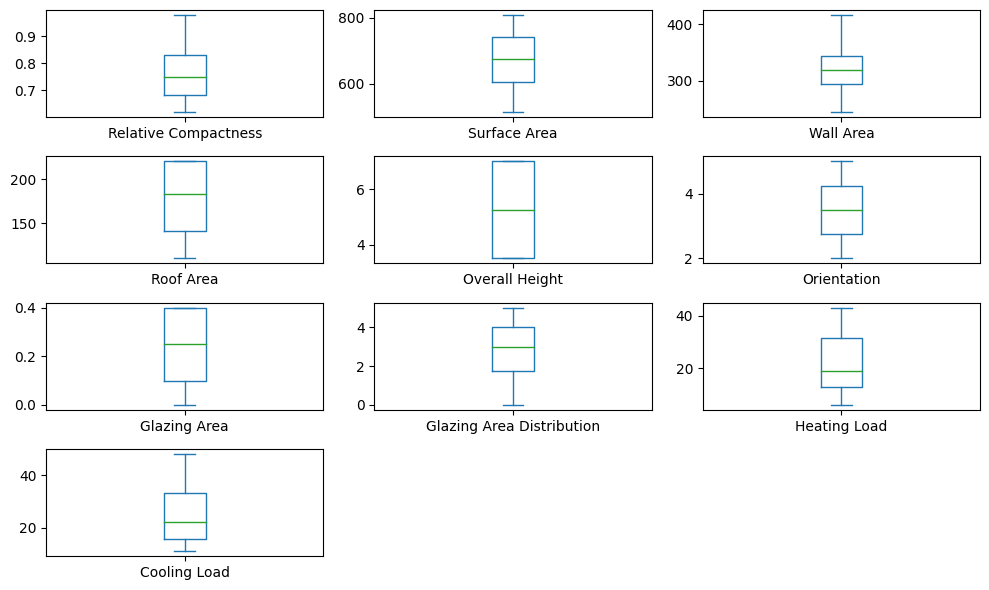

In [7]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

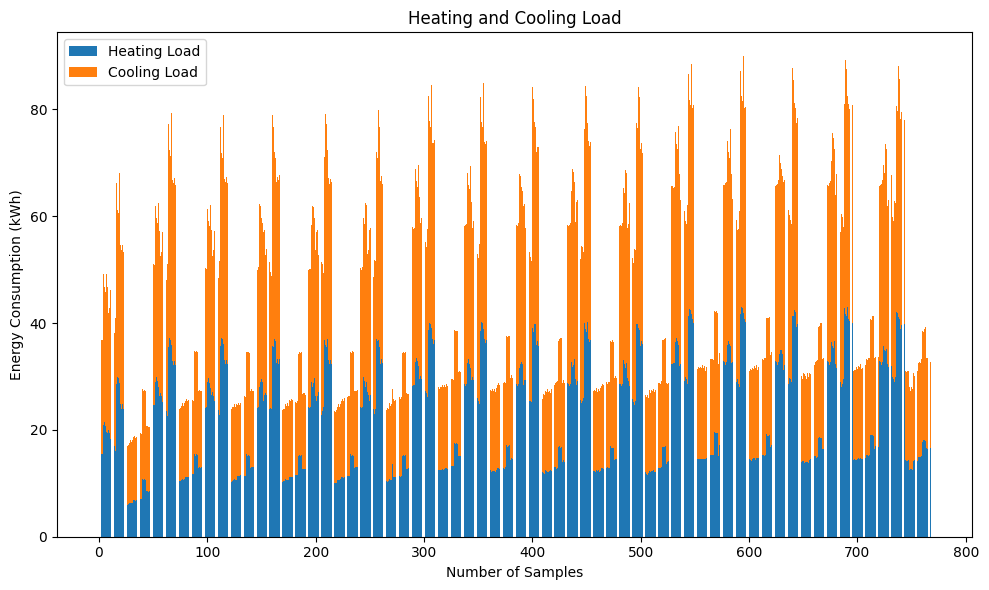

In [8]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


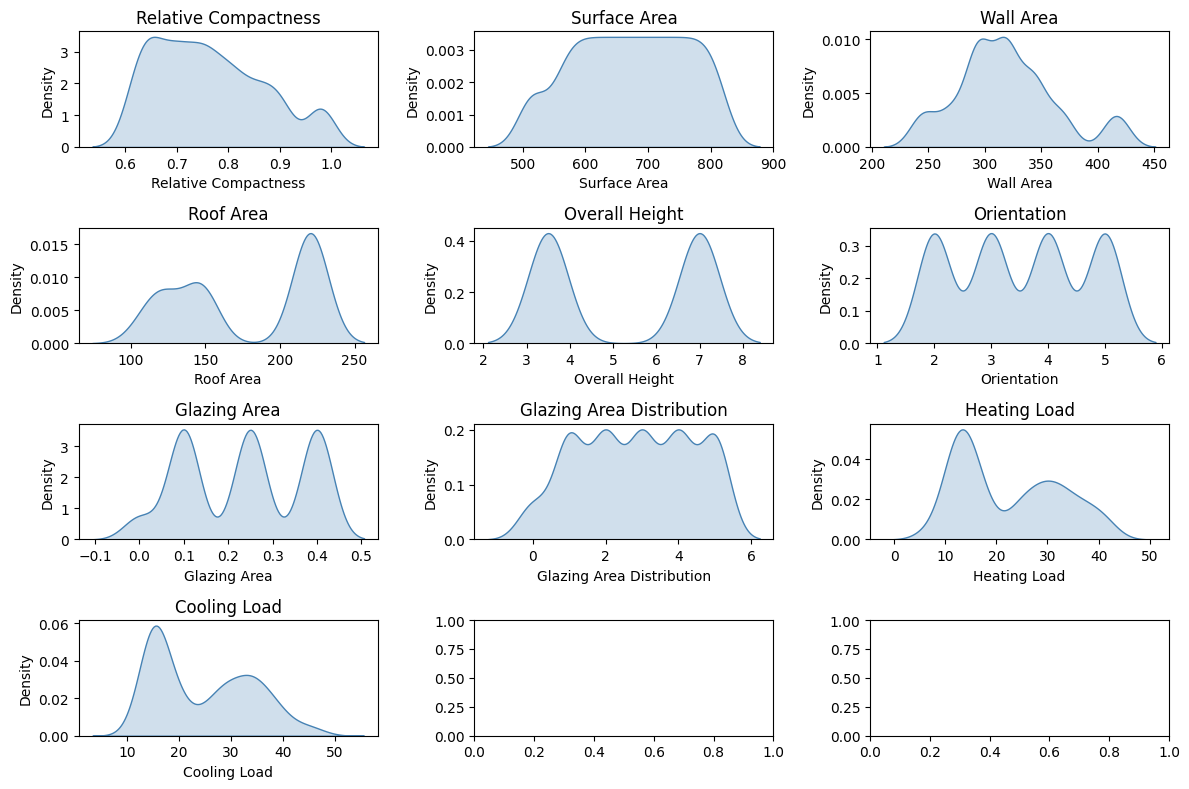

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array to simplify plotting
axes = axes.flatten()

# Loop through each feature and create a density plot
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', fill=True)
    axes[i].set_title(feature)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()

It appears that only surface area follows Gaussian distrbution. The nonlinearity of other featues suggest that this is a complicated dataset.

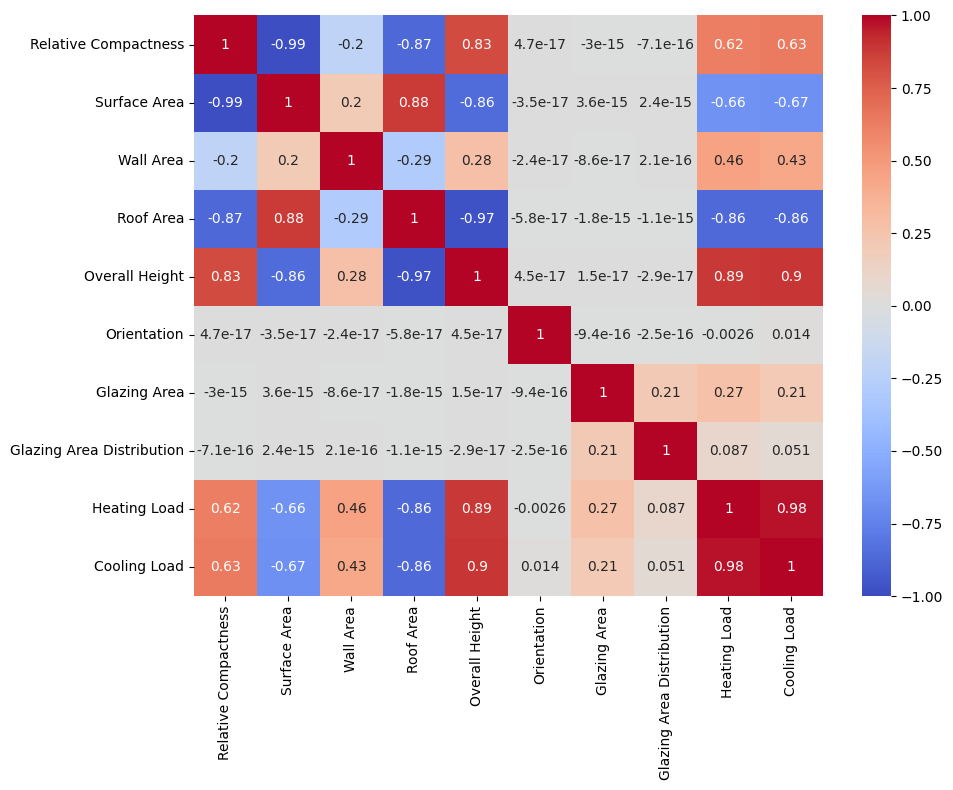

In [10]:
# correlation matrix between all pairs of attributes
corr_matrix = data.corr(method='pearson')

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

The correlation matrix indicates heating and coolind loads and energy consumption are strongly correlated to Overall Height and Relative Compactness. 

The Sobol indices are a measure of the importance of each input variable in a simulation model, with respect to its contribution to the output variability. They can be used to determine the most important input variables and to prioritize the areas for improvement in a building design.

In [11]:
# Define the problem for Sobol analysis
problem = {
    'num_vars': 8,
    'names': ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(8)]
}

In [12]:
# Load the fitted Random Forest model from disk
with open('finalized_model_multivariate.sav', 'rb') as file:
    model_RF = pickle.load(file)

In [13]:
N = 1024 # number of samples
# Generate samples
X_sobol = sobol_sample(problem, N, calc_second_order=False)

# Calculate the Sobol Indices for each target variable
y_sobol_0 = model_RF.predict(X_sobol)[:, 0]
Si_0 = sobol.analyze(problem, y_sobol_0, calc_second_order=False)

y_sobol_1 = model_RF.predict(X_sobol)[:, 1]
Si_1 = sobol.analyze(problem, y_sobol_1, calc_second_order=False)

The Sobol indices sensitivity analysis suggest that there is a strong correlation between Energy Consumption and three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness.

/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


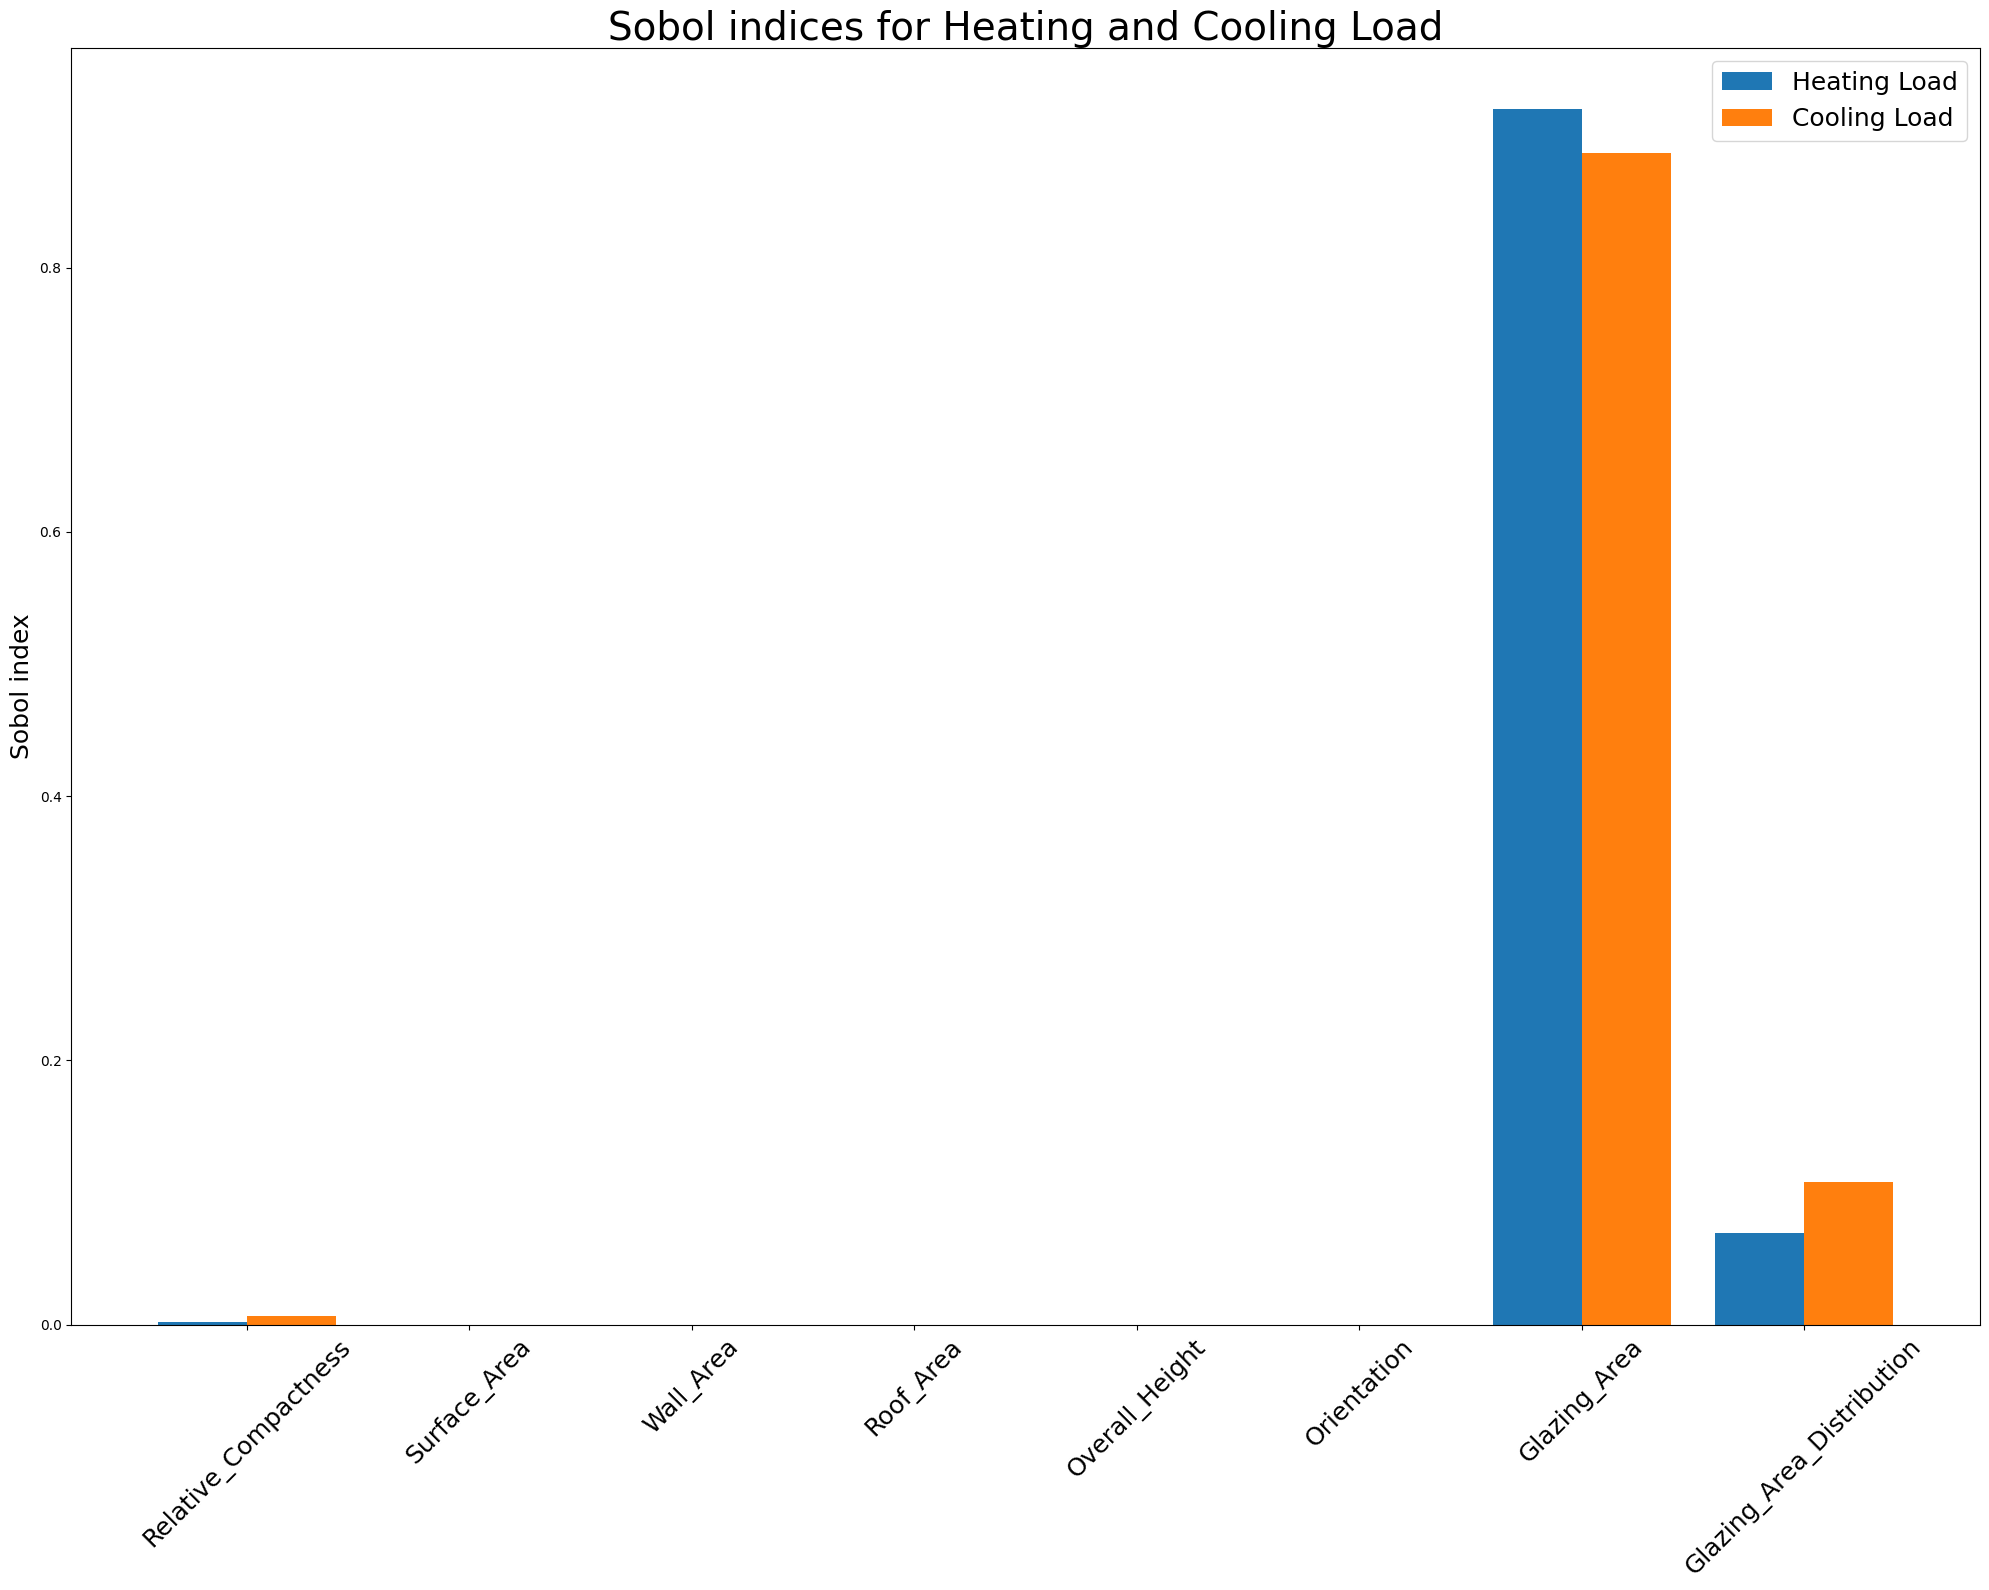

In [14]:
# Set figure size
fig, ax = plt.subplots(figsize=(20, 16))

# Set X axis labels and positions
names = problem['names']
x = np.arange(len(names))
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=18, rotation=45)

# Plot the bars for heating load
width = 0.4
rects1 = ax.bar(x - width/2, Si_0['S1'], width, label='Heating Load')

# Plot the bars for cooling load
rects2 = ax.bar(x + width/2, Si_1['S1'], width, label='Cooling Load')

# Add axis labels and title
ax.set_ylabel('Sobol index', fontsize=18)
ax.set_title('Sobol indices for Heating and Cooling Load', fontsize=28)

# Add legend
ax.legend(fontsize=18)

# Show plot
plt.show()

**3. Prepare Data**

In [15]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
dtype: int64


In [16]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [17]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [18]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Cooling Load']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

**4. Multi-objective Optimization using NSGA-II algorithm**

Once the Random Forest model was trained, we can use them as the surrogate model in the optimization process. This is a multi-objective optimization problem that attampted to optimize both heating and cooling load using input building design parameters.

Here are steps using the NSGA-II algorithm from the Pymoo library,  which is the most popular and a powerful interface for multi-objective optimization tasks, for optimization of building design parameters X targeting minimum heating and cooling loads y.

1. Define the problem and evaluate function from the surrogate model


2. Define the search space and NSGA-II algorithm parameters


3. Define the convergence termination criteria and callback function to the store optimal solution


4. Perform the optimization for a fixed number of iterations


5. After the run has completed, return the best solution and plot the fit value of the best solution found.

In [19]:
class BuildingDesignProblem(Problem):
    def __init__(self, x_min, x_max, model_RF):
        super().__init__(n_var=len(x_min), n_obj=2, n_constr=0, xl=x_min, xu=x_max)
        self.model_RF = model_RF

    def _evaluate(self, X, out, *args, **kwargs):
        # Predict heating and cooling loads using the Random Forest model
        y_pred = self.model_RF.predict(X)

        # Separate the two objectives (heating and cooling loads)
        heating_load = y_pred[:, 0]
        cooling_load = y_pred[:, 1]

        # Set the objectives
        out['F'] = np.column_stack([heating_load, cooling_load])

In [20]:
# Define the range of possible values for each building design parameters
x_min = X.min().tolist()
x_max = X.max().tolist()
print(x_min, x_max)

[0.62, 514.5, 245.0, 110.25, 3.5, 2.0, 0.0, 0.0] [0.98, 808.5, 416.5, 220.5, 7.0, 5.0, 0.4, 5.0]


In [21]:
# Initialize the problem
problem = BuildingDesignProblem(x_min, x_max, model_RF)

In [22]:
# Set up the NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=25,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=1.0/len(x_min), eta=20),
    eliminate_duplicates=True
)

In [23]:
# Define a convergence termination class
class ConvergenceTermination(Termination):
    def __init__(self, conv_threshold, conv_generations, n_max_gen):
        super().__init__()
        self.conv_threshold = conv_threshold
        self.conv_generations = conv_generations
        self.n_max_gen = n_max_gen
        self.best_fit_values = []
        self.conv_counter = 0
        self.converged_solution_X = None
        self.converged_solution_F = None

    # check for the convergence criterion
    def _do_continue(self, algorithm):
        return self.perc < 1.0
    
    # check the convergence progress
    def _update(self, algorithm):
        best_fit = algorithm.pop.get("F").min()
        self.best_fit_values.append(best_fit)
        
        if algorithm.n_gen >= self.n_max_gen:
            return 1.0

        if len(self.best_fit_values) > self.conv_generations:
            conv_rate = abs(self.best_fit_values[-1] - self.best_fit_values[-self.conv_generations]) / self.conv_generations
            if conv_rate < self.conv_threshold:
                self.conv_counter += 1
                if self.conv_counter >= 5:
                    # store the termination object and use it to print the converged solution and the objective value later
                    self.converged_solution_X = algorithm.pop[np.argmin(algorithm.pop.get("F"))].get("X")
                    self.converged_solution_F = algorithm.pop.get("F")
                    print(f"Algorithm has converged after {algorithm.n_gen} generations.")
                    return 1.0
            else:
                self.conv_counter = 0
        return algorithm.n_gen / self.n_max_gen

In [24]:
# Define the callback function to store the generation number along with the non-dominated solutions found at each generation
def generation_callback(algorithm):
    generation_number = algorithm.n_gen
    non_dominated_solutions = algorithm.pop.get("F")

In [25]:
# Perform the optimization
termination = ConvergenceTermination(conv_threshold=0.1, conv_generations=5, n_max_gen=50)

res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    callback=generation_callback,
    verbose=True,
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      125 |      1 |  0.000000E+00 |             f
     3 |      150 |      1 |  0.000000E+00 |             f
     4 |      175 |      1 |  0.000000E+00 |             f
     5 |      200 |      2 |  0.000000E+00 |             f
     6 |      225 |      3 |  0.000000E+00 |             f
     7 |      250 |      1 |  0.1172000000 |         ideal
     8 |      275 |      3 |  1.0000000000 |         ideal
     9 |      300 |      7 |  0.000000E+00 |             f
Algorithm has converged after 10 generations.
    10 |      325 |      9 |  0.000000E+00 |             f


We can see from the eps and n_nds that optimum solution was found in the first generation. Here's the meaning of the columns in the output:

- n_eval: Number of evaluations - It represents the total number of objective function evaluations performed so far in the optimization process. In each generation, a certain number of individuals are evaluated, and this number keeps track of the cumulative evaluations.

- n_nds: Number of non-dominated solutions - This shows the number of non-dominated solutions found in the current generation. Non-dominated solutions are part of the Pareto front and are the optimal solutions that cannot be improved in any objective without degrading another objective.

- eps: Epsilon - This value represents the epsilon-indicator (ε-indicator) which is a performance metric used to measure the convergence of the algorithm. A smaller ε-indicator value implies better convergence.

- indicator: Indicator - This column shows which indicator was used to calculate the ε-indicator value for that generation. Possible values include "f" for the hypervolume indicator and "ideal" for the ideal point indicator. The hypervolume indicator measures the volume of the dominated space by the non-dominated set, while the ideal point indicator measures the distance between the non-dominated set and the ideal point.

In [26]:
# Retrieve the termination object after the optimization
convergence = res.algorithm.termination

In [27]:
# Print the converged solution and corresponding objective value
min_values = [min(sublist) for sublist in zip(*convergence.converged_solution_F)]
print("Optimum values of heating and cooling loads (kWh) found:")
print(min_values)
print()
print("Converged solution (X values):")
for col_name, col_value in zip(X.columns, convergence.converged_solution_X):
    print(f"- {col_name}: {col_value}")

Optimum values of heating and cooling loads (kWh) found:
[21.376800000000003, 26.463699999999996]

Converged solution (X values):
- Relative Compactness: 0.7216034419460854
- Surface Area: 770.3148758719036
- Wall Area: 340.56382870024777
- Roof Area: 186.2633562131644
- Overall Height: 5.087926455533425
- Orientation: 2.209999226273186
- Glazing Area: 0.11566542080975531
- Glazing Area Distribution: 0.046742889832578904


/Users/user/Library/Python/3.8/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


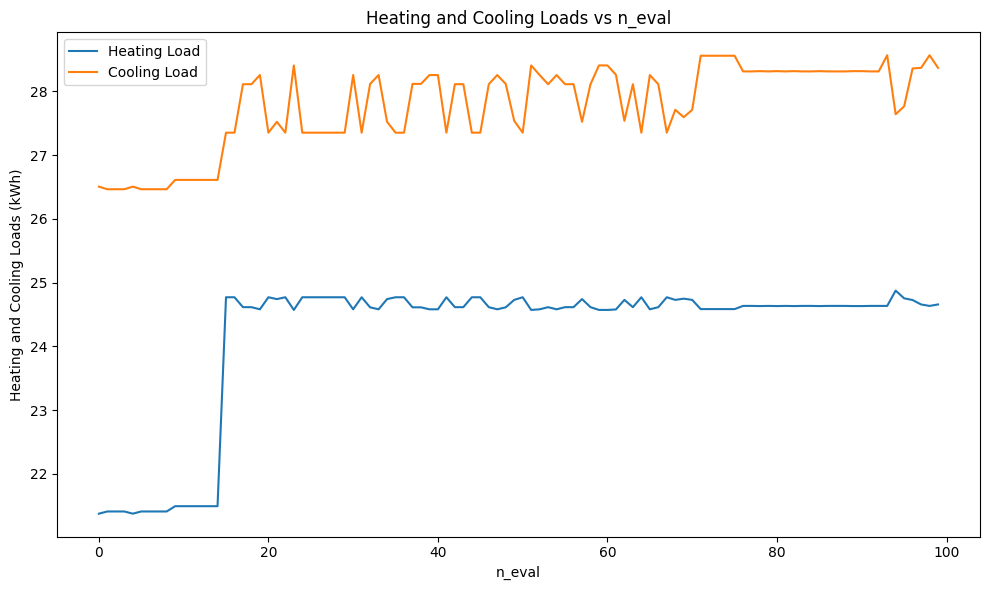

In [28]:
# Plot the optimum energy consumption of heating and cooling loads vs. n_eval at the converged n_gen (1 in this case)
plt.plot(convergence.converged_solution_F[:, 0], label="Heating Load")
plt.plot(convergence.converged_solution_F[:, 1], label="Cooling Load")

plt.title("Heating and Cooling Loads vs n_eval")
plt.xlabel("n_eval")
plt.ylabel("Heating and Cooling Loads (kWh)")
plt.legend()

plt.show()

**5. Conclusions**

- The results of the Sobol indices sensitivity analysis indicate that Energy Consumption is strongly correlated with three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness. These factors have the highest Sobol indices, indicating that they have the greatest impact on the Energy Consumption.

- The optimization results show that convergence was reached during the first iteration.

- When comparing the outcomes of multi-objective optimization with those of single-objective optimization, an optimal solution is found, which yields heating and cooling loads of 22.2026 kWh and 26.8402 kWh, respectively.

- Pymoo is not the sole option for multi-objective optimization; several other libraries and tools are available, including DEAP, MOEA, and Optunity. These alternatives can be tailored to specific problem requirements and preferences.